In [0]:
%%time
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', -1)

PATH = 'Задача 1/input/'

df = pd.read_csv(PATH + 'train.csv', index_col='doc_id')
test_df = pd.read_csv('Задача 1/input/test.csv', index_col='doc_id')

CPU times: user 13.7 s, sys: 1.46 s, total: 15.1 s
Wall time: 15.2 s


## gensim doc2vec

### Train

In [0]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['text'])]

In [0]:
%%time
vector_size = 100
model = Doc2Vec(vector_size=vector_size, window=2, min_count=2, workers=2)
model.build_vocab(documents)

CPU times: user 1min 21s, sys: 4.96 s, total: 1min 26s
Wall time: 1min 26s


Lets train doc2vec only on 1 epochs, because it use CPU and training time is large

In [0]:
%%time
# max_epochs = 1
# for epoch in range(max_epochs):
#     print('iteration {0}'.format(epoch))
#     model.train(documents,
#                 total_examples=model.corpus_count,
#                 epochs=model.iter)
#     # decrease the learning rate
#     model.alpha -= 0.0002
#     # fix the learning rate, no decay
#     model.min_alpha = model.alpha
model.train(documents, total_examples=model.corpus_count, epochs=model.iter)

CPU times: user 20min 38s, sys: 11.5 s, total: 20min 49s
Wall time: 12min 4s


In [0]:
model.save("/gdrive/My Drive/ITMO/d2v.model")

### Test

In [0]:
%%time
test_df['embeddings'] = test_df['text'].apply(model.infer_vector)

CPU times: user 1min 41s, sys: 2.66 s, total: 1min 44s
Wall time: 1min 44s


### Clustering

Before selecting number of clusters, lets see the overall structure of documents embeddings. It can give us some insights for choosing right value for number of clusters

In [0]:
# !pip install MulticoreTSNE

In [0]:
%%time
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_jobs=2)
Y = tsne.fit_transform(np.vstack(test_df['embeddings']))

CPU times: user 1min 54s, sys: 64.6 ms, total: 1min 54s
Wall time: 1min 4s


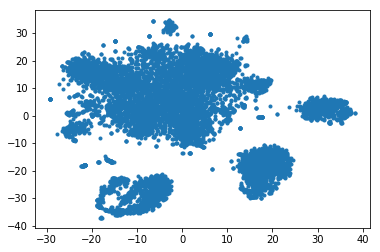

In [0]:
import matplotlib.pyplot as plt
plt.scatter(Y[:, 0], Y[:, 1], marker='.')

We can see 4 big clusters. But lets get a look also on the biggest cluster:

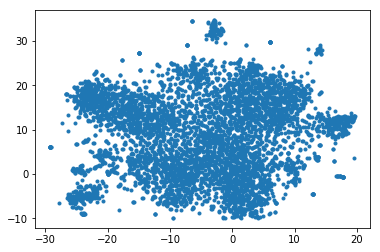

In [0]:
cluster_4 = Y[(Y[:, 0] < 20) & (Y[:, 1] > -10)]
plt.scatter(cluster_4[:, 0], cluster_4[:, 1], marker='.')

I think, we can extract 4 more clusters from the biggest - upper left, upper right, lower left, lower right

I will use AgglomerativeClustering. If take account of what we derive from TSNE, then 10 clusters will be good idea.

In [0]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=10)
test_df['label'] = clustering.fit_predict(np.vstack(test_df['embeddings']))

In [0]:
np.save('ITMO/gensim_embeddings.npy', np.vstack(test_df['embeddings']))
test_df['label'].to_csv('ITMO/gensim_labels.csv', header=True)

Lets look on result

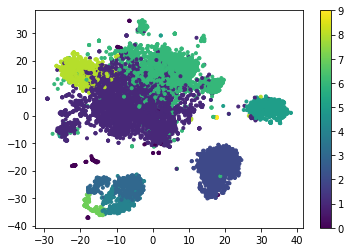

In [0]:
plt.scatter(Y[:, 0], Y[:, 1], marker='.', c=test_df['label'])
plt.colorbar();

In [0]:
%%time
groupped = test_df.groupby('label')['text'].sum()

CPU times: user 29.7 s, sys: 4.24 s, total: 33.9 s
Wall time: 33.9 s


In [0]:
from collections import Counter
from operator import itemgetter
ans = groupped.apply(lambda s: list(map(itemgetter(0), Counter(s.split(' ')).most_common(10))))

In [0]:
ans

label
0    [рублей, квартира, заказ, доставка, номер, тел, объекта, казани, наличии, стоимость]  
1    [квартира, цена, мебель, день, тел, техника, сдается, квартиру, сдам, дом]            
2    [коли, від, але, якщо, мене, він, щоб, день, його, хто]                               
3    [мен, бір, деп, бар, үшін, адам, емес, керек, сен, жоқ]                               
4    [мен, деп, бір, бар, үшін, болады, керек, бұл, және, деген]                           
5    [amp, house, remix, love, art, original, label, release, pht, amv]                    
6    [цена, продам, руб, наличии, состоянии, размер, грн, торг, обмен, куплю]              
7    [бір, мен, деп, бар, үшін, және, бұл, жоқ, алла, олар]                                
8    [минут, ингредиенты, масло, добавить, соль, тесто, приготовление, яйца, перец, лук]   
9    [ваши, сyммы, личные, руб, суммы, электронный, предлагаем, пишите, сообщения, кошелек]
Name: text, dtype: object

Not bad. But 1st and 2nd cluster very similar to each other, but algorithm didn't take it into account. Also we have clusters with texts on another languages, about food, e-money and so on

In [0]:
ans.apply(lambda el: ' '.join(el)).to_csv('/gdrive/My Drive/ITMO/gensim_topic_labels.csv', header=True)

### Evaluation of the result

#### Quantitative

Evaluate with [Silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering))

In [0]:
from sklearn.metrics import silhouette_score
print(silhouette_score(test_df['embeddings'], test_df['label']))

0.10626346


Silhouette score shows that clustering is far from ideal


In [0]:
test_df['label'].value_counts()

1    3121
6    1771
2    1032
3    566 
8    545 
5    535 
4    284 
7    121 
0    116 
9    9   
Name: label, dtype: int64

### Possible improvements

1) Train doc2vec with more epochs

2) Choose another clustering algorithm (instead of AgglomerativeClustering)

3) Choose another number of topics